<a href="https://colab.research.google.com/github/awiteck/DeepLearningAssignments/blob/main/AIT_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [3]:
with open('/content/drive/MyDrive/Frankenstein.txt') as f:
    lines = f.readlines()

In [4]:
with open('/content/drive/MyDrive/Frankenstein.txt') as f:
    frankenstein_flat_list=[word for line in f for word in line.split()]
with open('/content/drive/MyDrive/greatgatsby.txt') as f:
    greatgatsby_flat_list=[word for line in f for word in line.split()]

In [5]:
frank = open("/content/drive/MyDrive/Frankenstein.txt", "r")
gatsby = open("/content/drive/MyDrive/greatgatsby.txt", "r")

# Replace gets rid of all newline characters
# The [500:] gets rid of formatting stuff at beginning of text file
frank_data = frank.read().replace('\\\n', ' ')[500:]
gatsby_data = gatsby.read().replace('\\\n', ' ')[500:]

## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

In [6]:
len(frank_data), len(gatsby_data)

(422145, 284465)

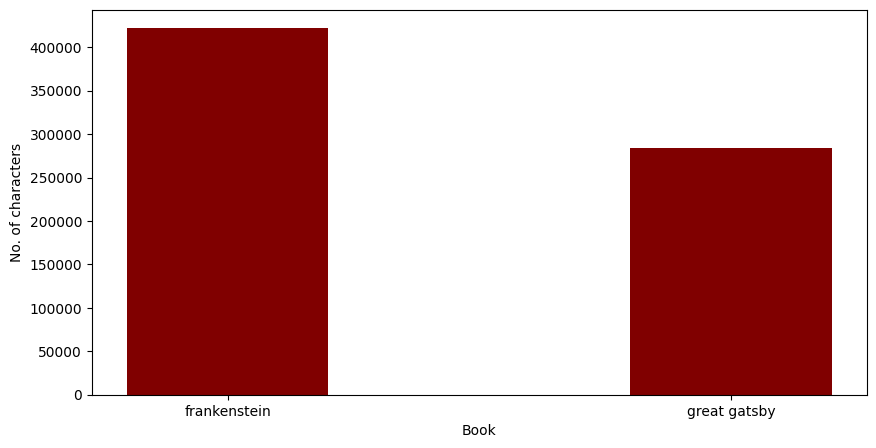

In [7]:
# creating the dataset
data = {'frankenstein':len(frank_data), 'great gatsby':len(gatsby_data)}
keys = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(keys, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Book")
plt.ylabel("No. of characters")
plt.show()

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [8]:
def split_string(data, n):
  return [data[i:i+n] for i in range(0, len(data), n)]

In [9]:
gatsby_split = split_string(gatsby_data, 60)[:-2]
frank_split = split_string(frank_data, 60)[:-2]

In [10]:
y = np.concatenate((np.zeros(len(gatsby_split)), (np.ones(len(frank_split)))))

In [11]:
concat_data = split_string(gatsby_data, 60)[:-2] + split_string(frank_data, 60)[:-2]
# random.shuffle(concat_data)

In [12]:
#concat_data

In [13]:
all_chars = sorted(list(set(frank_data + gatsby_data)))
char_to_indicies = dict((c, i) for i, c in enumerate(all_chars))

## Data splitting
Split the data into train, validate and test sets. Make 

In [14]:
def one_hot_encode(s, char_dict):
  result = np.zeros((len(s), len(char_dict)))
  for i in range(len(s)):
    result[i][char_dict[s[i]]] = 1
  return result

In [15]:
X = np.zeros((len(concat_data), 60, len(all_chars)))

In [16]:
for line in concat_data:
  if len(line) != 60:
    print(len(line))

In [17]:
for i in range(len(concat_data)):
  X[i] = one_hot_encode(concat_data[i], char_to_indicies)

In [18]:
X.shape, y.shape

((11774, 60, 79), (11774,))

In [19]:
X, y = shuffle(X, y)

In [20]:
train_split = 0.9
val_split = 0.8
X_train = X[:int(train_split * len(X))]
X_test = X[int(train_split * len(X)):]
Y_train = y[:int(train_split * len(y))]
Y_test = y[int(train_split * len(y)):]

In [21]:
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("Y_train: ", Y_train.shape)
print("Y_test: ", Y_test.shape)

X_train:  (10596, 60, 79)
X_test:  (1178, 60, 79)
Y_train:  (10596,)
Y_test:  (1178,)


## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [22]:
nb_filter       = 64   # number of filter/kernels in the convolutional layers
filter_length   = 48  # length of the filter/kernel in the convolutional layers
window_size     = X_train.shape[1] # the window size defined by the dataset
nb_features     = X_train.shape[2] # the number of features of the input data
nb_outputs      = 1 # the number of outputs (defined by the target data)

## Model training
Train the model and apply early stopping.

In [23]:
model = Sequential()
model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal', input_shape=(window_size, nb_features), padding='same'))
# model.add(MaxPooling1D())
model.add(Dropout(0.3))
model.add(Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling1D())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(nb_outputs, activation='sigmoid'))

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [24]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 60, 64)            242752    
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 64)            196672    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 64)            0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 6, 64)             0         
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                        

In [25]:
es = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")

In [26]:
history = model.fit(X_train, Y_train, 
          epochs=15, batch_size=32, 
          validation_split=0.2, # don't change the validation split
          callbacks=[es],
          verbose=2)

Epoch 1/15
265/265 - 34s - loss: 0.5539 - accuracy: 0.7173 - val_loss: 0.4910 - val_accuracy: 0.7693 - 34s/epoch - 128ms/step
Epoch 2/15
265/265 - 30s - loss: 0.4203 - accuracy: 0.8110 - val_loss: 0.4474 - val_accuracy: 0.7953 - 30s/epoch - 112ms/step
Epoch 3/15
265/265 - 29s - loss: 0.2602 - accuracy: 0.8922 - val_loss: 0.5476 - val_accuracy: 0.7594 - 29s/epoch - 108ms/step
Epoch 4/15
265/265 - 31s - loss: 0.1174 - accuracy: 0.9572 - val_loss: 0.6480 - val_accuracy: 0.7925 - 31s/epoch - 116ms/step
Epoch 5/15
265/265 - 29s - loss: 0.0710 - accuracy: 0.9736 - val_loss: 0.7040 - val_accuracy: 0.7892 - 29s/epoch - 111ms/step
Epoch 6/15
265/265 - 29s - loss: 0.0576 - accuracy: 0.9784 - val_loss: 0.7111 - val_accuracy: 0.7915 - 29s/epoch - 108ms/step
Epoch 7/15
265/265 - 29s - loss: 0.0519 - accuracy: 0.9811 - val_loss: 0.7457 - val_accuracy: 0.7967 - 29s/epoch - 108ms/step
Epoch 8/15
265/265 - 28s - loss: 0.0421 - accuracy: 0.9840 - val_loss: 0.7408 - val_accuracy: 0.7797 - 28s/epoch - 107

In [31]:
print(model.evaluate(X_test, Y_test))

37/37 [==============================] - 1s 26ms/step - loss: 0.4120 - accuracy: 0.8141
[0.41200920939445496, 0.814091682434082]


## Confusion matrix
Calculate and display the confusion matrix.

In [32]:
preds = model.predict(X_test)
preds = np.round(preds)

37/37 [==============================] - 1s 27ms/step


<Axes: >

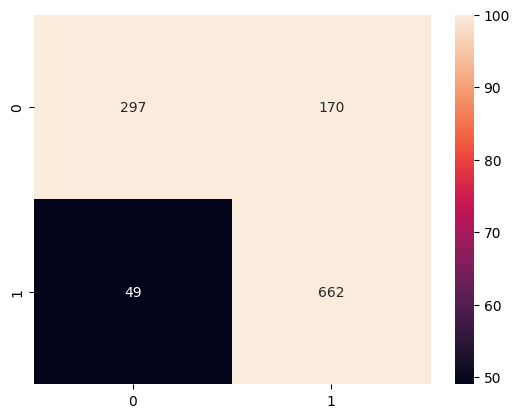

In [48]:
conf=confusion_matrix(Y_test.reshape(Y_test.shape[0],1),preds)
sns.heatmap(conf, annot=True, fmt='d', vmax=100)